# Final Project: Detecting bots in wikipedia  streaming data

1) Consider all the changes done in the wikipedia as stream.
** Check here: https://wikitech.wikimedia.org/wiki/RCStream

2) Each action is received in json format. 

3) Data is full of bots. There is a flag were programmers can 
indicate that an actions has been done by a bot.

4) Using this information as ground truth, develop a system able 
to classify users as bot or human.

5) Constrain: You need to sample, and just use the 20% of 
the data stream. 

6) Describe the distribution of edits per users and bots. 

7) Finally, train a Bloom Filter that filter out bots from the stream. 

* Find the correct parameters for the bloom filter having an 
error below 10%.

8) If you want to have a 100% you need to do this:

* Make your system to work with Spark Streaming (5%)

In [ ]:
from sseclient import SSEClient as EventSource
import time
import json

In [69]:
# Define helper functions

def fetch_raw(event_source, fetching_time_sec, message_types, wikis, event_decimation=5, print_log=False):
    observed_users = set()
    skipped_users = set()
    user_counter = 0
    start_time = time.time()
    for event in event_source:
        try:
            change = json.loads(event.data)
        except:
            # ignore message
            continue

        if change["type"] not in message_types or change["wiki"] not in wikis:
            # ignore message
            continue

        elapced_time = time.time() - start_time
        if elapced_time > fetching_time_sec:
            break

        yield (change)


def hash_user(wiki, id):
    return hash((wiki, id))

def fetch_users(event_source, fetching_time_sec, message_types, wikis, event_decimation=5, print_log=False):
    observed_users = set()
    skipped_users = set()
    user_counter = 0
    start_time = time.time()
    for event in event_source:
        try:
            change = json.loads(event.data)
        except:
            # ignore message
            continue

        if change["type"] not in message_types or change["wiki"] not in wikis:
            # ignore message
            continue

        user = hash_user(change["wiki"], change["title"], change["user"])
        if user in observed_users:
            if print_log:
                print(f"Message from user {user} saved")
            save_user = True
        elif user in skipped_users:
            if print_log:
                print(f"Message from user {user} skipped")
            save_user = False
        else:
            # new user   
            if user_counter % event_decimation == 0:
                if print_log:
                    print(f"+ Add new user {user}")
                observed_users.add(user)
                save_user = True
            else:
                if print_log:
                    print(f"- Add Skip user {user}")
                skipped_users.add(user)
                save_user = False
            user_counter += 1

        elapced_time = time.time() - start_time
        if elapced_time > fetching_time_sec:
            break

        if save_user:
            yield (change)

In [57]:
url = 'https://stream.wikimedia.org/v2/stream/recentchange'
message_types = {"edit"}
wikis = {"enwiki"}#, "wikidatawiki"}
wikis_str = "_".join(wikis)

In [70]:
fetching_time_sec = 800

raw_items = [change for change in fetch_raw(EventSource(url), fetching_time_sec, message_types, wikis)]

In [92]:
raw_items[0]

{'$schema': '/mediawiki/recentchange/1.0.0',
 'meta': {'uri': 'https://en.wikipedia.org/wiki/George_Santos',
  'request_id': '7853eaf3-e784-46d0-8030-5515bea95a3e',
  'id': '04b13719-4ad1-4018-b01e-419bd9fb1edb',
  'dt': '2023-11-21T19:51:25Z',
  'domain': 'en.wikipedia.org',
  'stream': 'mediawiki.recentchange',
  'topic': 'codfw.mediawiki.recentchange',
  'partition': 0,
  'offset': 785902126},
 'id': 1696879635,
 'type': 'edit',
 'namespace': 0,
 'title': 'George Santos',
 'title_url': 'https://en.wikipedia.org/wiki/George_Santos',
 'comment': 'added link',
 'timestamp': 1700596285,
 'user': 'TheHetStopper',
 'bot': False,
 'notify_url': 'https://en.wikipedia.org/w/index.php?diff=1186232574&oldid=1186214513',
 'minor': False,
 'length': {'old': 284532, 'new': 284675},
 'revision': {'old': 1186214513, 'new': 1186232574},
 'server_url': 'https://en.wikipedia.org',
 'server_name': 'en.wikipedia.org',
 'server_script_path': '/w',
 'wiki': 'enwiki',
 'parsedcomment': 'added link'}

# Analyze bot behaviour

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(raw_items)
df['length_old'] = df.apply(lambda x: x['length']['old'], axis=1)
df['length_new'] = df.apply(lambda x: x['length']['new'], axis=1)
df['length_diff'] = df['length_new'] - df['length_old']
len(df)

1458

## Bot vs Real user edit length

In [76]:
df.sample()

,$schema,meta,id,type,namespace,title,title_url,comment,timestamp,user,...,length,revision,server_url,server_name,server_script_path,wiki,parsedcomment,length_old,length_new,length_diff
252,/mediawiki/recentchange/1.0.0,{'uri': 'https://en.wikipedia.org/wiki/User:Al...,1696880151,edit,2,User:AlexNewArtBot/BiharSearchResult,https://en.wikipedia.org/wiki/User:AlexNewArtB...,"most recent results, added 1, removed 6, total 47",1700596425,InceptionBot,...,"{'old': 22742, 'new': 20587}","{'old': 1186077056, 'new': 1186232861}",https://en.wikipedia.org,en.wikipedia.org,/w,enwiki,"most recent results, added 1, removed 6, total 47",22742,20587,-2155


(0.0, 50.0)

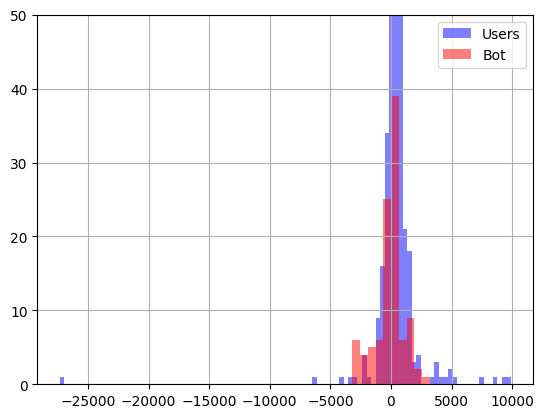

In [91]:
ax1 = plt.subplot(111)
df[~df['bot']]['length_diff'].hist(ax=ax1, color='blue', label='Users', alpha=0.5, bins=100)
df[df['bot']]['length_diff'].hist(ax=ax1, color='red', label='Bot', alpha=0.5)
ax1.legend(loc='best')

ax1.set_ylim((0, 50))

Observations:
- real users makes bigger changes (>3k symbols per edit)
- changes between +/- 3k edited changes make both users and bots, so events are not distinguishable
- bots has bot in the name (too obvious)
- bots generates comments in structured form

## Bot behaviour

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 12.0)

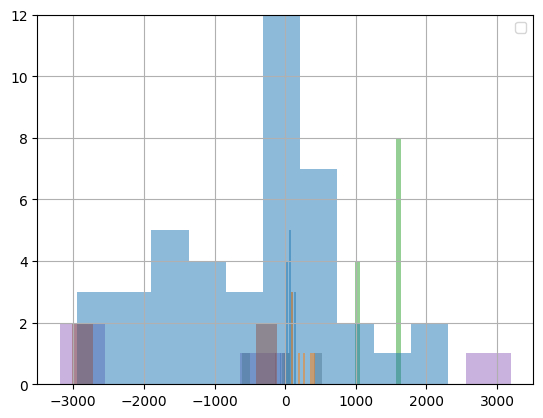

In [87]:
ax1 = plt.subplot(111)
df[df['bot']].groupby('user')['length_diff'].hist(ax=ax1, alpha=0.5)
ax1.legend(loc='best')

ax1.set_ylim((0, 12))

In [98]:
df[df['bot']][['user', 'title']].value_counts().reset_index().sort_values('count')

,user,title,count
0,AnomieBOT,1969 Miles - Festiva De Juan Pins,1
74,AnomieBOT,History of the Belgian Americans in Metro Detroit,1
73,AnomieBOT,Misinformation in the 2023 Israel-Hamas war,1
72,AnomieBOT,Plaskett's Star,1
71,AnomieBOT,Rick and Morty - Let the Rick One In,1
...,...,...,...
29,RMCD bot,Wikipedia:Requested moves/Current discussions ...,1
28,RMCD bot,Wikipedia:Requested moves/Current discussions ...,1
27,InternetArchiveBot,Celestina Boninsegna,1
37,InternetArchiveBot,Celestina Bottego,1


In [100]:
df[df['bot']]['user'].unique()

array(['Mz7 (bot)', 'InceptionBot', 'AnomieBOT', 'Cewbot',
       'InternetArchiveBot', 'Citation bot', 'HBC AIV helperbot5',
       'Cyberbot I', 'EarwigBot', 'DatBot', 'Bot1058', 'MusikBot',
       'FireflyBot', 'DeltaQuadBot', 'Legobot', 'RMCD bot', 'SineBot'],
      dtype=object)

In [125]:
df[df['bot']]['comment'].sample(20).unique()

array(['Updating report', 'most recent scoring',
       'Update logs for past 7 days',
       'Add: date. | [[:en:WP:UCB|Use this bot]]. [[:en:WP:DBUG|Report bugs]]. | Suggested by Abductive | [[Category:People named in the Panama Papers]] | #UCB_Category 163/280',
       'Add: date. | [[:en:WP:UCB|Use this bot]]. [[:en:WP:DBUG|Report bugs]]. | Suggested by Abductive | [[Category:People named in the Panama Papers]] | #UCB_Category 175/280',
       'Add: work. Removed parameters. Some additions/deletions were parameter name changes. | [[:en:WP:UCB|Use this bot]]. [[:en:WP:DBUG|Report bugs]]. | Suggested by Abductive | [[Category:People named in the Panama Papers]] | #UCB_Category 63/280',
       'Giving DYK credit for [[Canticle I: My beloved is mine and I am his]] on behalf of [[User:Z1720|Z1720]]',
       '[[User:DeltaQuadBot|DeltaQuadBot]] UAA Updating Run Time.',
       'Copying assessment table to wiki.',
       'Adding/updating {{OnThisDay}} for 2023-11-21.  Errors? [[User:AnomieB

Observations:

- The bot title and comment seems to be significant features

# Collect data for model training

In [ ]:
fetching_time_sec = 30000
url = 'https://stream.wikimedia.org/v2/stream/recentchange'
message_types = {"edit"}
wikis = {"enwiki"}#, "wikidatawiki"}
wikis_str = "_".join(wikis)

with open('sample1.jsonl', 'w') as fout:
    for item in fetch_users(EventSource(url), fetching_time_sec, message_types, wikis):
        fout.write(json.dumps(item) + "\n")


# Read data

In [151]:
with open('sample.jsonl', 'r') as fin:
    samples = list(map(json.loads, fin.readlines()))

df = pd.DataFrame(samples)
df.drop_duplicates(['user', 'title', 'comment'], inplace=True)

len(df)

11289

In [152]:
df[['user', 'bot' ,'comment']].value_counts().reset_index().sort_values('count', ascending=True)

,user,bot,comment,count
3996,Reddqueen,False,Submitting using [[WP:AFCSW|AfC-submit-wizard]],1
5335,2600:1006:B025:890E:A8AF:672:FD61:B452,False,,1
5334,2409:4062:4D02:8813:B749:D866:7924:620D,False,/* Killing */ new section,1
5333,2600:1009:B05D:21E8:5972:77A5:D17C:1CD6,False,/* Results by congressional district */,1
5332,24.44.147.86,False,/* History */,1
...,...,...,...,...
4,Векочел,False,De-link common terms ([[User:Ohconfucius/scrip...,85
3,WP 1.0 bot,True,Copying assessment table to wiki.,102
2,InceptionBot,True,most recent scoring,115
1,Onel5969,False,Disambiguating links to [[Kushan]] (link chang...,134


In [203]:
import math 
import hashlib
import mmh3 
from bitarray import bitarray 
  
  
class BloomFilter(object): 
    def __init__(self, filter_capacity, fp_error_rate):
        # number of stored items in bloom filter, spreaded between bits (mask)
        self._filter_capacity = filter_capacity
        self._fp_error_rate = fp_error_rate
        self._size = BloomFilter.calculate_size(self._filter_capacity, self._fp_error_rate)
        self._hash_functions = [
            lambda x: int.from_bytes(hashlib.sha256(x.encode('utf-8')).digest(), 'big'), 
            # mmh3.hash
        ]
        self._mask_array = [0] * self._size

    @staticmethod
    def calculate_size(items_number, fp_error_rate):
        ''' 
        Size of bit array(m) to used using formula:
        m = -(n * lg(p)) / (lg(2)^2) 
        '''        
        return int(-(filter_size * (math.log(fp_error_rate) / (math.log(2) ** 2))))

    def fit(self, X, Y):
        for x, y in zip(X, Y):
            if not y:
                continue
            for hash_func in self._hash_functions:
                index = hash_func(x) % self._size
                self._mask_array[index] = 1

    def predict_one(self, item):
        for hash_func in self._hash_functions:
            index = hash_func(item) % self._size
            if not self._mask_array[index]:
                return False
        return True

    def predict(self, items):
        return [self.predict_one(item) for item in items]

In [204]:
def extract_features(item):
    return str([
        item['user'],
        # item['comment'],
        # item['length']['new'] - item['length']['old'],
    ])
def extract_label(item):
    return item['bot']

X = list(map(extract_features, df.to_dict('records')))
Y = list(map(extract_label, df.to_dict('records')))

In [205]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [206]:
model = BloomFilter(10, 0.01)
model.fit(X_train, y_train)

In [207]:
y_pred = model.predict(X_test)

In [208]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      0.65      0.79      2001
        True       0.27      1.00      0.42       257

    accuracy                           0.69      2258
   macro avg       0.63      0.82      0.61      2258
weighted avg       0.92      0.69      0.75      2258

